**INSTALLS**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/ML4641_Team1/Clustering

/content/drive/MyDrive/ML4641_Team1/Clustering


In [3]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import Image, display_svg, SVG

# avoid "Arial font not found" warnings
import logging
logging.getLogger('matplotlib.font_manager').setLevel(level=logging.CRITICAL)

**HELPER FUNCTIONS**

Function 1: Cleans Data based off of Z-score [working]

In [ ]:
# This functions removes all rows from the DataFrame df whose feature value has z-score above 3 or below -3
def remove_outliers_Z_score(df: pd.DataFrame, feature: str):
    z_scores = np.abs(stats.zscore(df[feature]))
    too_high_indices =  np.where(z_scores > 3)[0]
    too_low_indices = np.where(z_scores < -3)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 2: Cleans Data based off of IQR [not working]

In [ ]:
# This function removes all rows from the DataFrame df whose feature value is above Q3 + 1.5 * IQR or below Q1 - 1.5 * IQR
# UPDATE: This is giving me issues. Probably better to use Z-score to remove outliers for this dataset
def remove_outliers_IQR(df: pd.DataFrame, feature: str):
    Q1 = np.percentile(df[feature], 25, method = 'midpoint')
    Q3 = np.percentile(df[feature], 75, method = 'midpoint')
    IQR = Q3 - Q1
    too_high_indices = np.where(df[feature] >= Q3 + 1.5 * IQR)[0]
    too_low_indices = np.where(df[feature] <= Q1 - 1.5 * IQR)[0]
    df.drop(index = too_high_indices, inplace = True)
    df.drop(index = too_low_indices, inplace = True)

Function 3: Splits pandas DataFrame into training set and testing set
(Note: Clustering is unsupervised, so it does not make sense to have a train/test split.)

In [ ]:
# This function splits a pandas DataFrame into a training set and a test set, specificed by the train_ratio.
def split_dataset(df: pd.DataFrame, train_ratio: float):
  train_indices = np.random.rand(len(df)) < train_ratio
  return df[train_indices], df[~train_indices]

Function 4: Performs one-hot encoding, converting categorical (especially binary) to numerical data.

In [4]:
# This function converts a categorical feature (original_feature) to numerical data (encoded_feature), via one-hot encoding.
# Typically converts yes/no to 1/0.
def encode_cat_to_num(df: pd.DataFrame, original_feature: str, encoded_feature: str):
    df[original_feature] = df[original_feature].astype('category')
    df[encoded_feature] = df[original_feature].cat.codes

**LOAD DATA**

In [5]:
# Housing prices: https://www.kaggle.com/datasets/yasserh/housing-prices-dataset/data
housing_prices_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Clustering/kaggle_housing_prices.csv")

# Realtor data: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset. Note that this dataset is from Puerto Rico and the US Northeast.
realtor_data_df = pd.read_csv("/content/drive/MyDrive/ML4641_Team1/Clustering/kaggle_realtor_data.csv")

**VISUALIZE DATA**

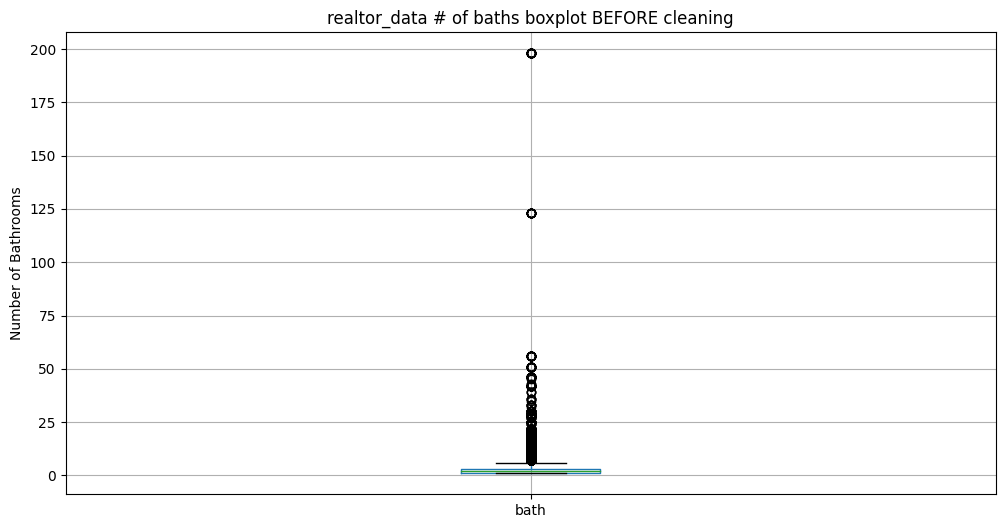

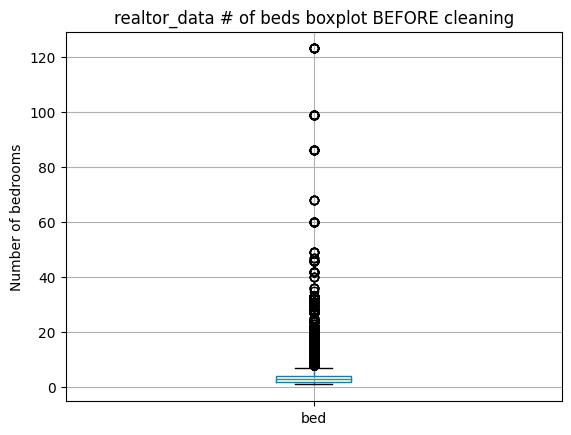

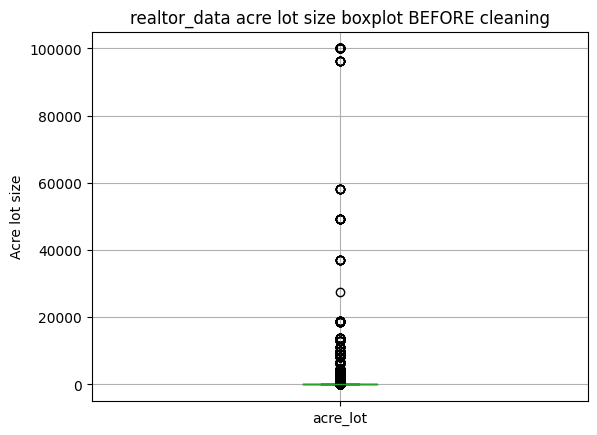

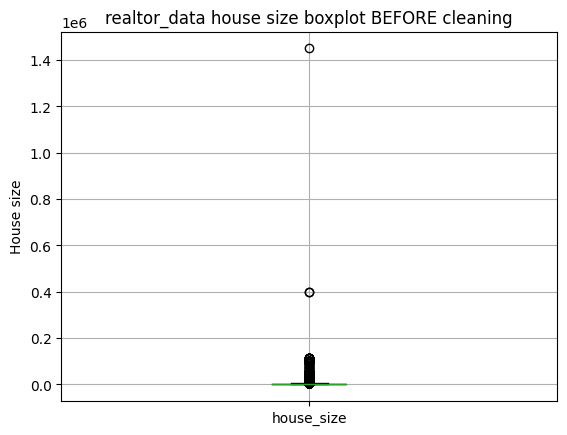

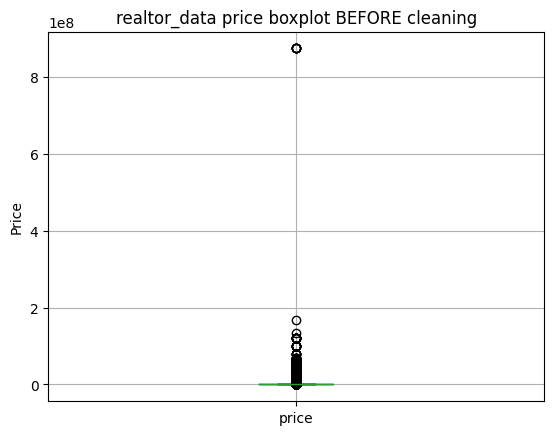

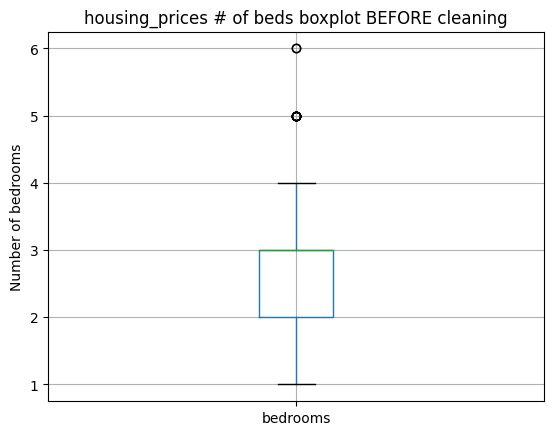

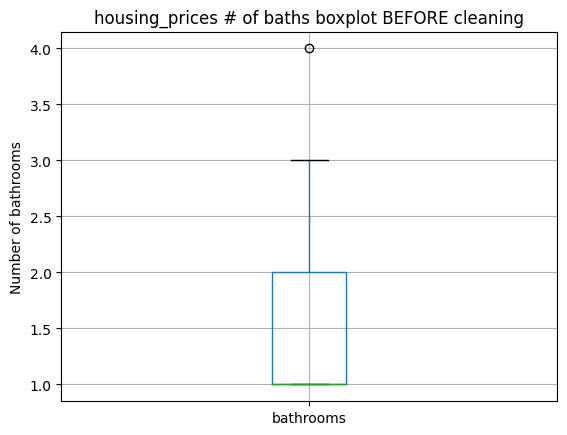

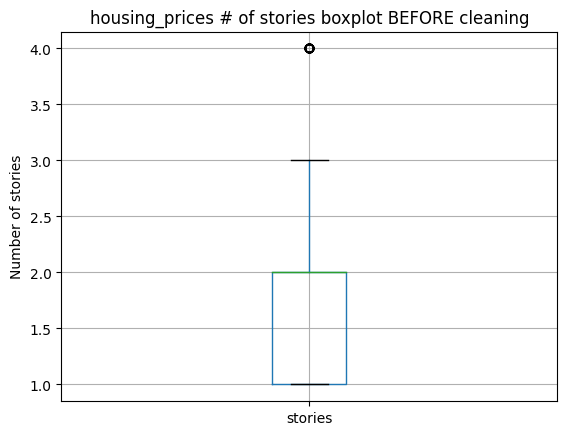

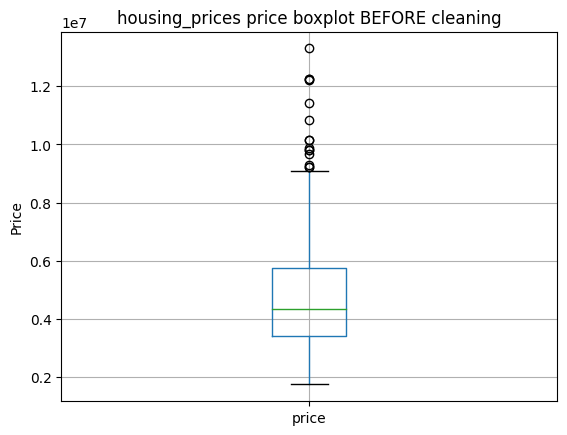

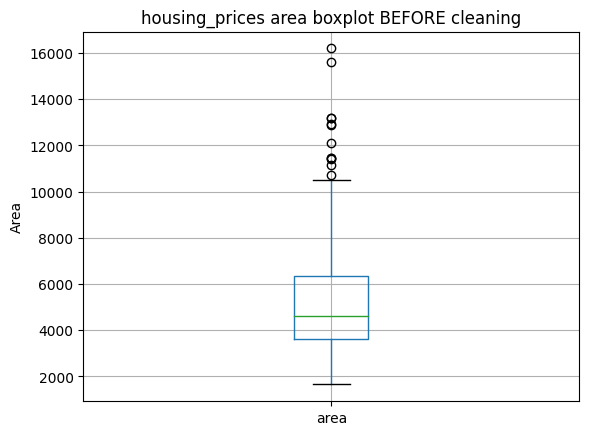

<Figure size 640x480 with 0 Axes>

'\nI think housing_prices is the better dataset, and the one we should use. The range of values for number of bedrooms, bathrooms, stories, etc. are clearly within reasonable range,\nwhereas in realtor_data some values are quite exorbitant (e.g. 100 or 200 bathrooms) and do not really make sense.\n'

In [ ]:
# Visualize the data- this will be helpful in deciding which dataset to use and (possibly) removing outliers.

plt.figure(figsize=(12, 6))

#########################
# realtor_data
#########################

# boxplot of number of bathrooms
realtor_data_df.boxplot(column='bath')
plt.title('realtor_data # of baths boxplot BEFORE cleaning')
plt.ylabel('Number of Bathrooms')
plt.show()

# Would a house really have 100 or 200 bathrooms? Could it be a mansion or mega commercial building?

# boxplot of number of bedrooms
realtor_data_df.boxplot(column='bed')
plt.title('realtor_data # of beds boxplot BEFORE cleaning')
plt.ylabel('Number of bedrooms')
plt.show()

# Again, some houses have like 100 or 120 bathrooms. Need to determine how to handle outliers.

# boxplot of acre lot size
realtor_data_df.boxplot(column='acre_lot')
plt.title('realtor_data acre lot size boxplot BEFORE cleaning')
plt.ylabel('Acre lot size')
plt.show()

# boxplot of house size
realtor_data_df.boxplot(column='house_size')
plt.title('realtor_data house size boxplot BEFORE cleaning')
plt.ylabel('House size')
plt.show()

# boxplot of price
realtor_data_df.boxplot(column='price')
plt.title('realtor_data price boxplot BEFORE cleaning')
plt.ylabel('Price')
plt.show()

#########################
# housing_prices
#########################

# boxplot of number of bedrooms
housing_prices_df.boxplot(column='bedrooms')
plt.title('housing_prices # of beds boxplot BEFORE cleaning')
plt.ylabel('Number of bedrooms')
plt.show()

# boxplot of number of bathrooms
housing_prices_df.boxplot(column='bathrooms')
plt.title('housing_prices # of baths boxplot BEFORE cleaning')
plt.ylabel('Number of bathrooms')
plt.show()

# boxplot of number of stories
housing_prices_df.boxplot(column='stories')
plt.title('housing_prices # of stories boxplot BEFORE cleaning')
plt.ylabel('Number of stories')
plt.show()

# boxplot of price
housing_prices_df.boxplot(column='price')
plt.title('housing_prices price boxplot BEFORE cleaning')
plt.ylabel('Price')
plt.show()

# boxplot of area
housing_prices_df.boxplot(column='area')
plt.title('housing_prices area boxplot BEFORE cleaning')
plt.ylabel('Area')
plt.show()
plt.tight_layout()  # Adjust layout to not overlap
plt.show()

"""
I think housing_prices is the better dataset, and the one we should use. The range of values for number of bedrooms, bathrooms, stories, etc. are clearly within reasonable range,
whereas in realtor_data some values are quite exorbitant (e.g. 100 or 200 bathrooms) and do not really make sense.
"""


**CLEAN AND TRAIN**

**CLEANING/PROCESSING DATA**

In [6]:
#################################################
############# First clean the data. #############
#################################################

print("-----STARTING-----\n")

# We agreed that housing_prices numerical attributes are fine as they are (i.e. no outliers), but we need to convert categorical attributes to numerical.

encoder = OneHotEncoder()
encode_cat_to_num(housing_prices_df, 'mainroad', 'has_mainroad')
encode_cat_to_num(housing_prices_df, 'guestroom', 'has_guestroom')
encode_cat_to_num(housing_prices_df, 'basement', 'has_basement')
encode_cat_to_num(housing_prices_df, 'hotwaterheating', 'has_hot_water_heating')
encode_cat_to_num(housing_prices_df, 'airconditioning', 'has_AC')
encode_cat_to_num(housing_prices_df, 'prefarea', 'in_preferred_area')

mapping = {'furnished': 2, 'semi-furnished': 1, 'unfurnished': 0}
housing_prices_df['is_furnished'] = housing_prices_df['furnishingstatus'].map(mapping)

# Fill all missing values with the mode of their respective column
housing_prices_df_encoded = housing_prices_df.fillna(housing_prices_df.mode().iloc[0])

# Save final cleaned dataframe as csv file.
housing_prices_df_encoded.to_csv("/content/drive/MyDrive/ML4641_Team1/Clustering/housing_prices_encoded.csv")

print("\n-----FINISHED-----")

-----STARTING-----


-----FINISHED-----


**DIMENSIONALITY REDUCTION**

In [7]:
#################################################################
############ Now we reduce the number of dimensions. ############
#################################################################

print("-----STARTING-----\n")

columns_of_interest = housing_prices_df_encoded[["price", "area", "bedrooms", "bathrooms", "stories", "parking", "has_mainroad", "has_guestroom", "has_basement", "has_hot_water_heating",
                                                "has_AC", "in_preferred_area", "is_furnished"]]
feature_names = columns_of_interest.columns
# Standardize the data (from columns_of_interest).
scaler = StandardScaler()
columns_of_interest_scaled = scaler.fit_transform(columns_of_interest)

# Use backward feature elimination or forward feature selection to reduce dimensionality- currently we have 13 features. (reference: https://www.analyticsvidhya.com/blog/2018/08/dimensionality-reduction-techniques-python/)
X = columns_of_interest.drop(columns = ['price'], axis = 1, inplace = False)
y = columns_of_interest['price']
# Perform forward feature selection (ffs)
ffs = f_regression(X, y) # f_regression returns a tuple- an array of F-scores and an array of P-values

# Only keep the 3 features with the highest F-scores. This will make the results easier to visualize.
f_scores = ffs[0]
features = X.columns
features_to_f_scores_dict = dict(zip(features, f_scores))
sorted_features = sorted(features_to_f_scores_dict.items(), key=lambda x: x[1], reverse=True)
kept_features = [feature[0] for feature in sorted_features[:3]]

print("kept_features:", kept_features)

print("\n-----FINISHED-----")

-----STARTING-----

kept_features: ['area', 'bathrooms', 'has_AC']

-----FINISHED-----


**DBSCAN**

-----STARTING DBSCAN-----

Estimated number of clusters: 4
Estimated number of noise points: 509


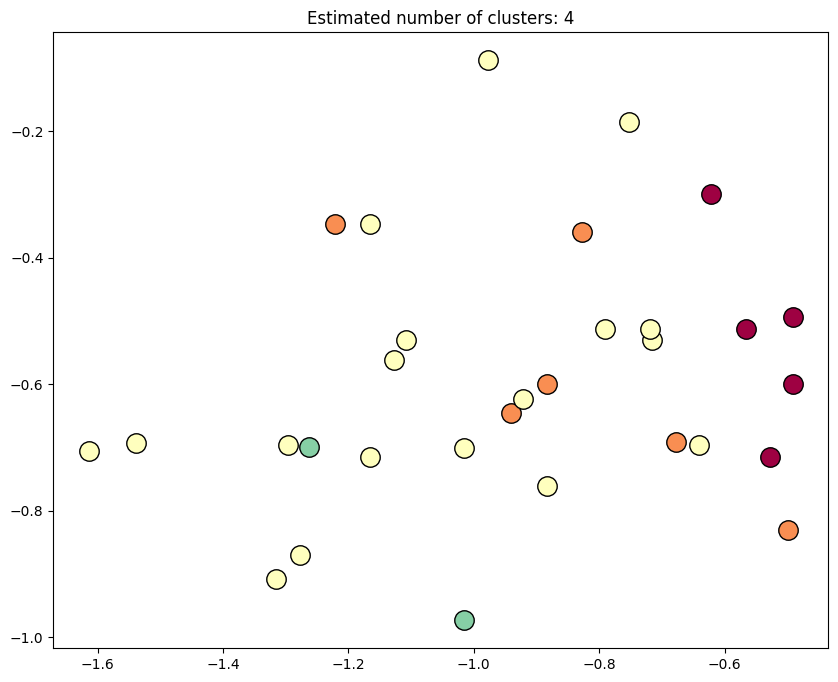


-----FINISHED DBSCAN-----


In [8]:
#################################################
############ Now we train our model. ############
#################################################

# DBSCAN
print("-----STARTING DBSCAN-----\n")

dbscan = DBSCAN(eps = 0.5, min_samples = 5)
dbscan_result = dbscan.fit(columns_of_interest_scaled)

# Generate core samples mask for areas of high density.
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Visualize DBSCAN
labels = dbscan.labels_
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
num_noise_points = list(labels).count(-1)

print("Estimated number of clusters:", num_clusters)
print("Estimated number of noise points:", num_noise_points)

# Plot the clusters
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]
    class_member_mask = (labels == k)
    xy = columns_of_interest_scaled[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

plt.title('Estimated number of clusters: %d' % num_clusters)
plt.show()

print("\n-----FINISHED DBSCAN-----")

**K-MEANS**

-----STARTING K-MEANS-----



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

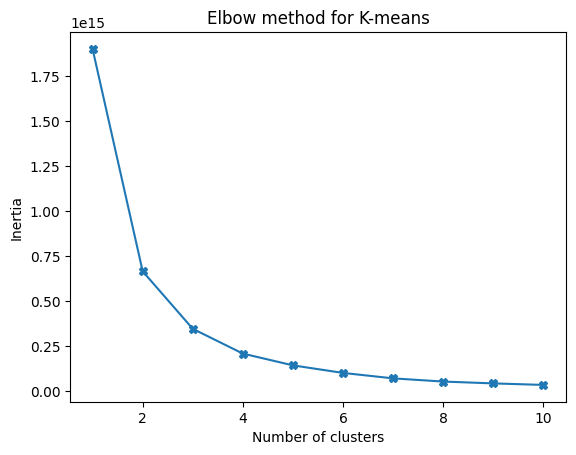

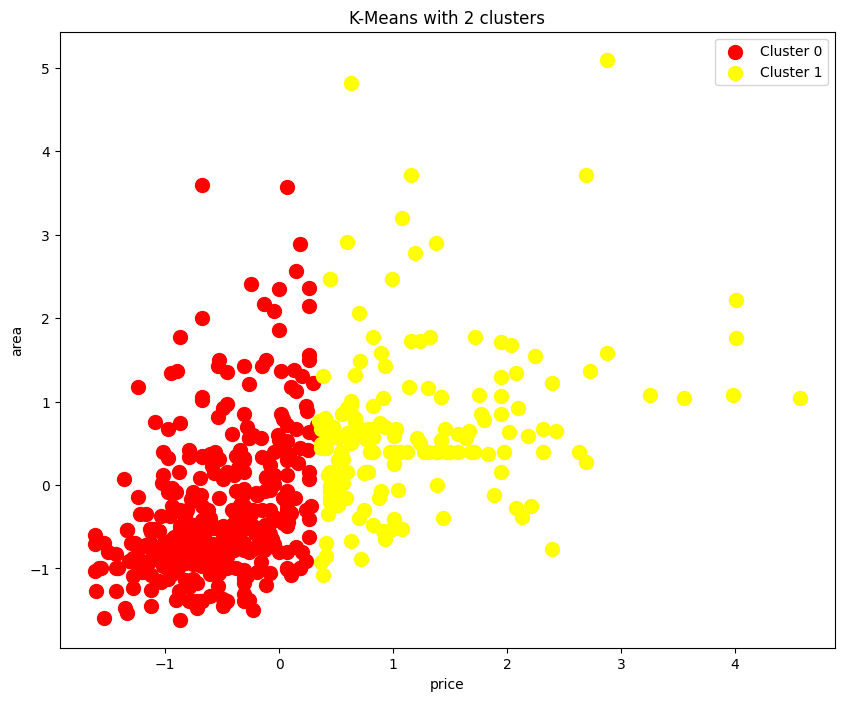

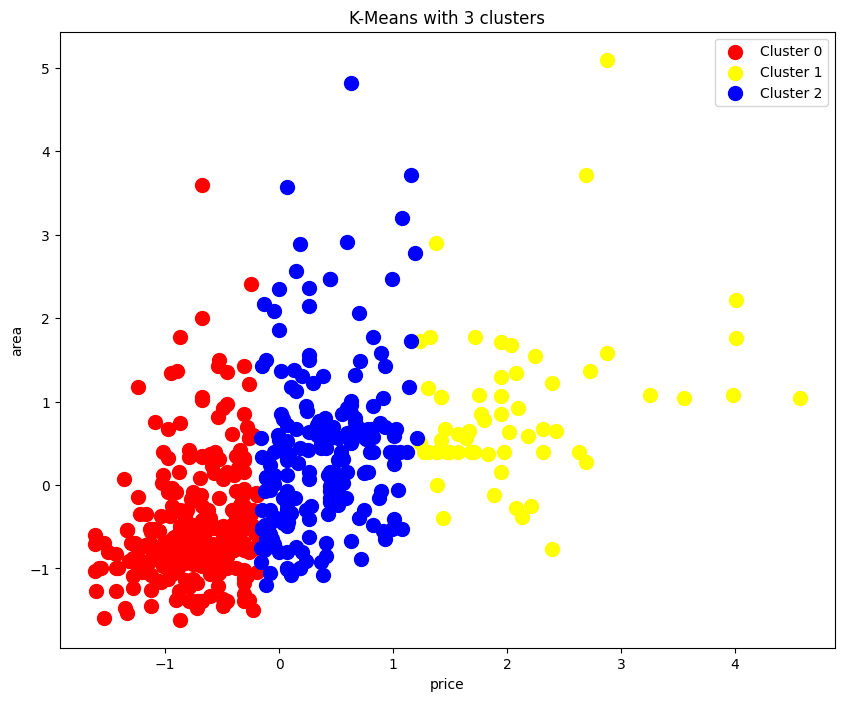

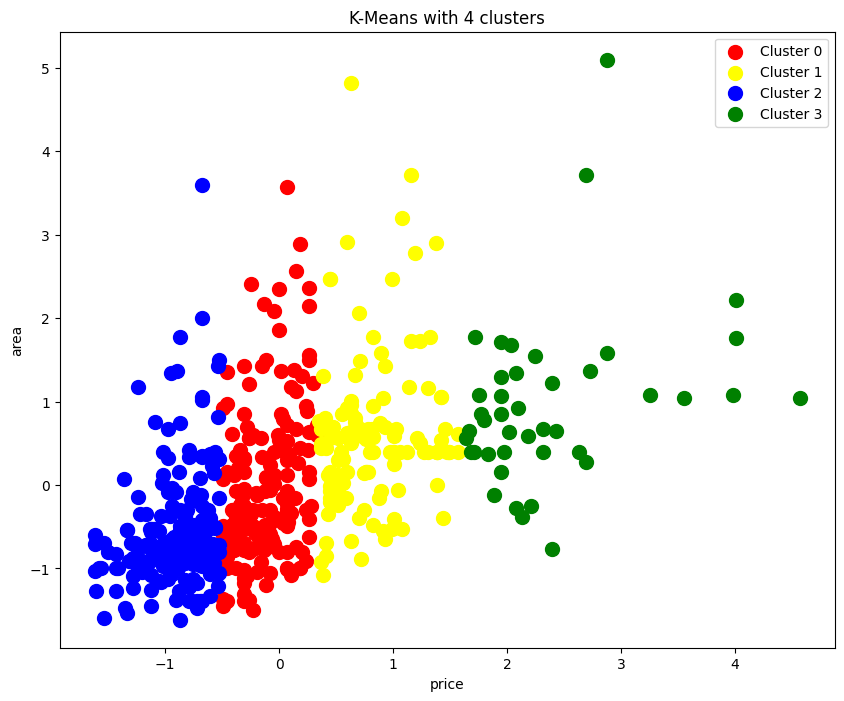


-----FINISHED K-MEANS-----


In [9]:
# K-MEANS
print("-----STARTING K-MEANS-----\n")

# Use the elbow method to find the best value of K.

k_means = None
inertias = [] # Inertia measures how well a dataset is clustered
for i in range(1, 11): # Try all values 1 to 11.
    k_means = KMeans(n_clusters = i)
    k_means.fit(columns_of_interest)
    inertias.append(k_means.inertia_)

# Display results to identify the elbow.
plt.plot(range(1, 11), inertias, marker = 'X')
plt.title('Elbow method for K-means')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

# Based on the visualization, it appears than 2 is the best value of K, but 3 and 4 also look reasonable.

# K-Means with 2 clusters:

k_means = KMeans(n_clusters = 2, n_init = 10)
k_means.fit(columns_of_interest)

# Visualize the clustering.
plt.figure(figsize=(10, 8))
plt.title('K-Means with 2 clusters')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 0, 0],
            columns_of_interest_scaled[k_means.labels_ == 0, 1],
            s=100, c='red', label='Cluster 0')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 1, 0],
            columns_of_interest_scaled[k_means.labels_ == 1, 1],
            s=100, c='yellow', label='Cluster 1')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

# K-Means with 3 clusters:

k_means = KMeans(n_clusters = 3, n_init = 10)
k_means.fit(columns_of_interest)

# Visualize the clustering.
plt.figure(figsize=(10, 8))
plt.title('K-Means with 3 clusters')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 0, 0],
            columns_of_interest_scaled[k_means.labels_ == 0, 1],
            s=100, c='red', label='Cluster 0')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 1, 0],
            columns_of_interest_scaled[k_means.labels_ == 1, 1],
            s=100, c='yellow', label='Cluster 1')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 2, 0],
            columns_of_interest_scaled[k_means.labels_ == 2, 1],
            s=100, c='blue', label='Cluster 2')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

# K-Means with 4 clusters:

k_means = KMeans(n_clusters = 4, n_init = 10)
k_means.fit(columns_of_interest)

# Visualize the clustering.
plt.figure(figsize=(10, 8))
plt.title('K-Means with 4 clusters')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 0, 0],
            columns_of_interest_scaled[k_means.labels_ == 0, 1],
            s=100, c='red', label='Cluster 0')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 1, 0],
            columns_of_interest_scaled[k_means.labels_ == 1, 1],
            s=100, c='yellow', label='Cluster 1')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 2, 0],
            columns_of_interest_scaled[k_means.labels_ == 2, 1],
            s=100, c='blue', label='Cluster 2')
plt.scatter(columns_of_interest_scaled[k_means.labels_ == 3, 0],
            columns_of_interest_scaled[k_means.labels_ == 3, 1],
            s=100, c='green', label='Cluster 3')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

print("\n-----FINISHED K-MEANS-----")

**GMM**

-----STARTING GMM-----



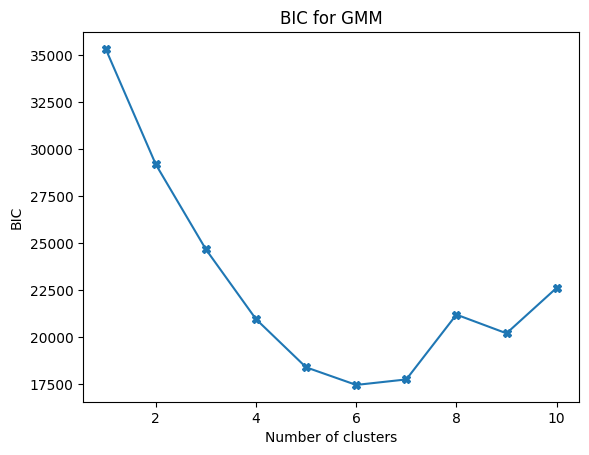

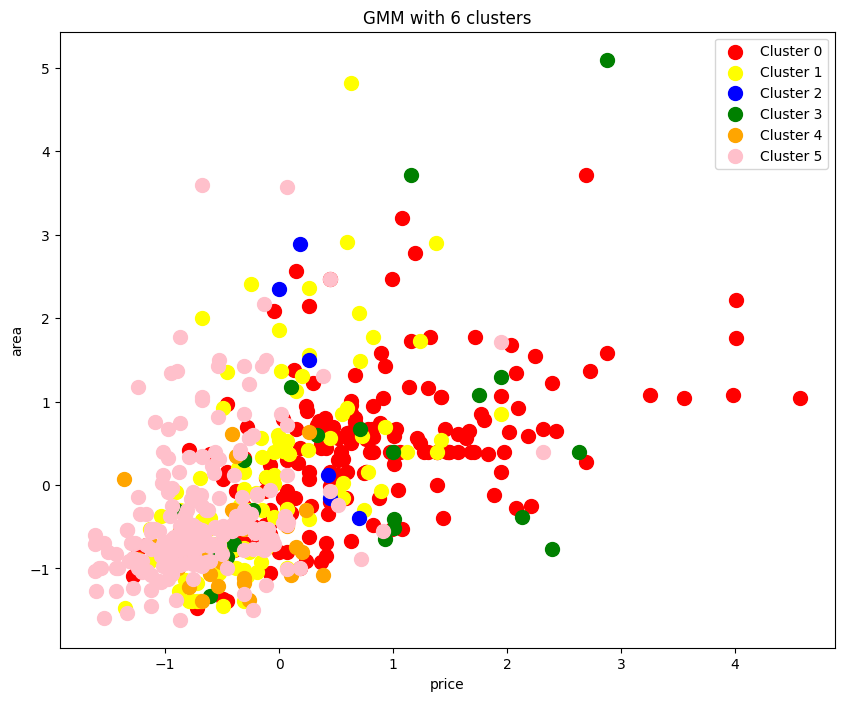


-----FINISHED GMM-----


In [ ]:
# GMM
print("-----STARTING GMM-----\n")

# Use the BIC scores to find the best value of K.

gmm = None
bic = [] # BIC measures how well a dataset is clustered- the lower the better.
for i in range(1, 11): # Try all values 1 to 11.
    gmm = GaussianMixture(n_components = i, random_state=0)
    gmm.fit(columns_of_interest)
    bic.append(gmm.bic(columns_of_interest))

# Display results to identify the best K.
plt.plot(range(1, 11), bic, marker = 'X')
plt.title('BIC for GMM')
plt.xlabel('Number of clusters')
plt.ylabel('BIC')
plt.show()

# Based on the graph, it appears that we should use K = 6.
gmm = GaussianMixture(n_components = 6, n_init = 10, random_state=0)
gmm_labels = gmm.fit_predict(columns_of_interest)

# Visualize the clustering.
plt.figure(figsize=(10, 8))
plt.title('GMM with 6 clusters')
plt.scatter(columns_of_interest_scaled[gmm_labels == 0, 0],
            columns_of_interest_scaled[gmm_labels == 0, 1],
            s=100, c='red', label='Cluster 0')
plt.scatter(columns_of_interest_scaled[gmm_labels == 1, 0],
            columns_of_interest_scaled[gmm_labels == 1, 1],
            s=100, c='yellow', label='Cluster 1')
plt.scatter(columns_of_interest_scaled[gmm_labels == 2, 0],
            columns_of_interest_scaled[gmm_labels == 2, 1],
            s=100, c='blue', label='Cluster 2')
plt.scatter(columns_of_interest_scaled[gmm_labels == 3, 0],
            columns_of_interest_scaled[gmm_labels == 3, 1],
            s=100, c='green', label='Cluster 3')
plt.scatter(columns_of_interest_scaled[gmm_labels == 4, 0],
            columns_of_interest_scaled[gmm_labels == 4, 1],
            s=100, c='orange', label='Cluster 4')
plt.scatter(columns_of_interest_scaled[gmm_labels == 5, 0],
            columns_of_interest_scaled[gmm_labels == 5, 1],
            s=100, c='pink', label='Cluster 5')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()
plt.show()

print("\n-----FINISHED GMM-----")

**EVALUATE ACCURACY IN DETAIL**


In [ ]:
print("-----STARTING-----\n")

# Note that we want to make silhouette score close to 1, maximize the Calinski-Harabasz index, and minimize Davies-Bouldin index.

# DBSCAN accuracy evaluation
print("-----DBSCAN accuracies-----")
dbscan_labels = dbscan.labels_
silhouette = silhouette_score(columns_of_interest_scaled, dbscan_labels)
print("Silhouette Score:", silhouette)
cal_har = calinski_harabasz_score(columns_of_interest_scaled, dbscan_labels)
print("Calinski-Harabasz Index:", cal_har)
davies_bouldin = davies_bouldin_score(columns_of_interest_scaled, dbscan_labels)
print("Davies-Bouldin Index:", davies_bouldin)

# K-Means accuracy evaluation
print("\n-----K-Means accuracies-----")
k_means = None
for k in range(2, 5): # Note that we tried K = 2, 3, and 4 for K-Means.
    print("\n-----K-Means with", k, "clusters-----")
    k_means = KMeans(n_clusters=k, n_init=10)
    k_means.fit(columns_of_interest_scaled)

    # Silhouette Score
    silhouette = silhouette_score(columns_of_interest_scaled, k_means.labels_)
    print("Silhouette Score:", silhouette)

    # Calinski-Harabasz Index
    cal_har = calinski_harabasz_score(columns_of_interest_scaled, k_means.labels_)
    print("Calinski-Harabasz Index:", cal_har)

    # Davies-Bouldin Index
    davies_bouldin = davies_bouldin_score(columns_of_interest_scaled, k_means.labels_)
    print("Davies-Bouldin Index:", davies_bouldin)

# GMM accuracy evaluation
print("\n-----GMM accuracies-----")
silhouette = silhouette_score(columns_of_interest_scaled, gmm_labels)
print("Silhouette Score:", silhouette)
cal_har = calinski_harabasz_score(columns_of_interest_scaled, gmm_labels)
print("Calinski-Harabasz Index:", cal_har)
davies_bouldin = davies_bouldin_score(columns_of_interest_scaled, gmm_labels)
print("Davies-Bouldin Index:", davies_bouldin)

print("\n-----FINISHED-----")

-----STARTING-----

-----DBSCAN accuracies-----
Silhouette Score: -0.18707307274001764
Calinski-Harabasz Index: 6.182089437243131
Davies-Bouldin Index: 1.3571312867411092

-----K-Means accuracies-----

-----K-Means with 2 clusters-----
Silhouette Score: 0.19720861390886454
Calinski-Harabasz Index: 110.02377547399512
Davies-Bouldin Index: 2.129314981138082

-----K-Means with 3 clusters-----
Silhouette Score: 0.16150905135122215
Calinski-Harabasz Index: 87.0236352335191
Davies-Bouldin Index: 1.989455784259576

-----K-Means with 4 clusters-----
Silhouette Score: 0.17250978214823456
Calinski-Harabasz Index: 79.68900965832557
Davies-Bouldin Index: 1.9907834210480944

-----GMM accuracies-----
Silhouette Score: 0.08665692335927525
Calinski-Harabasz Index: 39.40906437336789
Davies-Bouldin Index: 3.0697599270489992

-----FINISHED-----
